## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import requests

from cv2 import rectangle
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [3]:
import torch

In [4]:
import tensorflow as tf
BATCH_SIZE = 16

2025-09-05 19:46:03.996132: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757094364.007086 3356632 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757094364.010501 3356632 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-05 19:46:04.021711: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
from torchvision.transforms.functional import to_pil_image, to_tensor, resize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
!wget "https://unsplash.com/photos/MXvcHk-zCIs/download?force=true&w=640" -O "img.jpg"

Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/home/frederic.boisnard/.wget-hsts'. HSTS will be disabled.
--2025-09-05 19:46:10--  https://unsplash.com/photos/MXvcHk-zCIs/download?force=true&w=640
Resolving unsplash.com (unsplash.com)... 151.101.193.181, 151.101.1.181, 151.101.129.181, ...
Connecting to unsplash.com (unsplash.com)|151.101.193.181|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://images.unsplash.com/photo-1475266698552-c3349f5e1360?ixlib=rb-4.1.0&q=85&fm=jpg&crop=entropy&cs=srgb&dl=toa-heftiba-MXvcHk-zCIs-unsplash.jpg&w=640 [following]
--2025-09-05 19:46:10--  https://images.unsplash.com/photo-1475266698552-c3349f5e1360?ixlib=rb-4.1.0&q=85&fm=jpg&crop=entropy&cs=srgb&dl=toa-heftiba-MXvcHk-zCIs-unsplash.jpg&w=640
Resolving images.unsplash.com (images.unsplash.com)... 199.232.82.208, 2a04:4e42:54::720
Connecting to images.unsplash.com (images.unsplash.com)|199

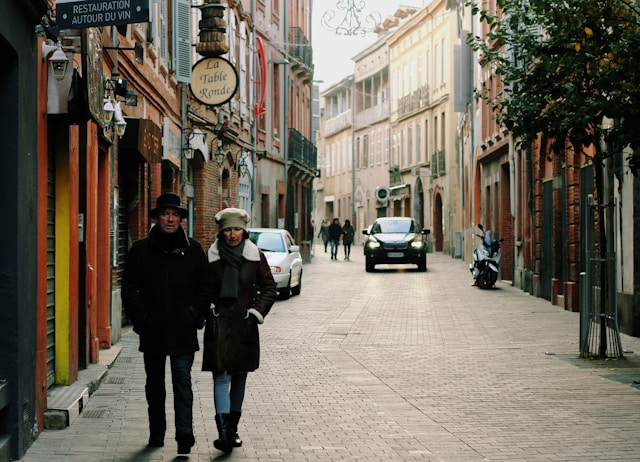

In [7]:
# street from Toulouse
url = "https://unsplash.com/photos/MXvcHk-zCIs/download?force=true&w=640"

# image = Image.open(requests.get(url, stream=True).raw)
image = Image.open("img.jpg")

# get a torch tensor
torch_image = to_tensor(image)

# batch the image
visualizable_torch_inputs = torch_image.unsqueeze(0)

# visualize image
to_pil_image(visualizable_torch_inputs[0])

In [8]:
visualizable_torch_inputs.shape

torch.Size([1, 3, 462, 640])

## Load SSD

In [9]:
import torchvision.transforms as T

In [10]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

nb_classes = len(CLASSES)
print(nb_classes)

91


In [11]:
from torchvision.models.detection import ssdlite320_mobilenet_v3_large, SSDLite320_MobileNet_V3_Large_Weights
from torchvision.ops import nms

# Step 1: Initialize model with the best available weights
weights = SSDLite320_MobileNet_V3_Large_Weights.COCO_V1
model = ssdlite320_mobilenet_v3_large(weights=weights)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
processed_torch_inputs = preprocess(visualizable_torch_inputs)

In [12]:
torch_predictions = model(processed_torch_inputs)[0]

In [13]:
torch_predictions.keys()

dict_keys(['boxes', 'scores', 'labels'])

In [14]:
torch_predictions['boxes'].shape, torch_predictions['scores'].shape, torch_predictions['labels'].shape

(torch.Size([300, 4]), torch.Size([300]), torch.Size([300]))

In [15]:
torch_predictions['scores'][0:10]

tensor([0.9920, 0.5451, 0.3471, 0.1541, 0.1531, 0.1259, 0.1185, 0.1146, 0.1116,
        0.1097], grad_fn=<SliceBackward0>)

In [16]:
torch_predictions['labels'][0:10]

tensor([1, 1, 3, 3, 1, 3, 3, 3, 1, 1])

In [17]:
torch_predictions['boxes']

tensor([[119.8235, 202.1370, 220.7547, 460.1033],
        [201.9642, 223.6381, 275.1527, 435.7001],
        [208.3832, 220.3257, 294.4546, 293.9687],
        ...,
        [257.1643,  97.2399, 294.5249, 164.8087],
        [ 75.3187, 168.8389, 215.9316, 293.4228],
        [307.4195, 201.4283, 320.0387, 221.5405]], grad_fn=<StackBackward0>)

1 image, 300 boites, 300 scores (normalised / softmaxed), 300 labels (class_id)

## Obj Detection Wrapper

In [19]:
# from boxes_model_wrapper import TorchvisionBoxesModelWrapper
from xplique.utils_functions.object_detection.torch.box_model_wrapper import TorchvisionBoxesModelWrapper

od_model = TorchvisionBoxesModelWrapper(model, nb_classes=nb_classes)
results = od_model(visualizable_torch_inputs)

## Visu SSD

In [25]:
from xplique.plots.display_image_with_boxes import display_image_with_boxes
from xplique.utils_functions.object_detection.common.box_manager import BoxFormat

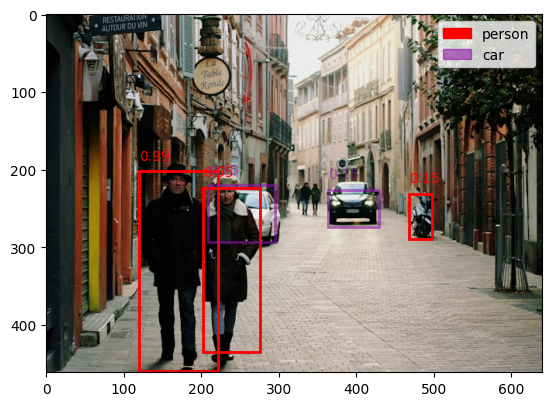

In [27]:
# class labels to color mapping
label_to_color = {'person': 'r',
                  'car': "#8F15A894",
                  'motorcycle': 'y'}

fig = display_image_with_boxes(image, results[0].cpu().detach(), BoxFormat.XYXY, False, CLASSES, label_to_color, accuracy=0.15)

# Attribution

In [29]:
# Checks gradients
from xplique.utils_functions.object_detection.torch.gradients_check import check_model_gradients
check_model_gradients(od_model, visualizable_torch_inputs)

Gradients OK - sum=2958418.250000


True

## Occlusion

In [38]:
from xplique.attributions import Saliency
from xplique.commons.operators import object_detection_operator
from xplique.wrappers import TorchWrapper

# we need to wrap our model with TorchWrapper to be able to use xplique tools with it
od_model = od_model.eval()
torch_wrapped_model = TorchWrapper(od_model, device=device, is_channel_first=True)

In [ ]:
# transform torch inputs to tensorflow format
tf_inputs = visualizable_torch_inputs.permute(0, 2, 3, 1)
tf_inputs = tf_inputs.detach().cpu().numpy()
targets = torch_wrapped_model(tf_inputs)

In [ ]:
# check operation output
import xplique
operator = xplique.Tasks.OBJECT_DETECTION_BOX_PROBA
scores = operator(torch_wrapped_model, tf_inputs, targets)
print(scores)

tf.Tensor([0.09616007], shape=(1,), dtype=float32)


In [ ]:
from xplique.attributions import Occlusion
explainer = Occlusion(torch_wrapped_model, operator=xplique.Tasks.OBJECT_DETECTION, batch_size=1, patch_size=(100, 100), patch_stride=(50, 50))

In [51]:
from xplique.utils_functions.object_detection.tf.box_manager import filter_boxes as filter_boxes_tf
box_to_explain = filter_boxes_tf(targets, class_id=CLASSES.index('person'))
print(f"box_to_explain len: {len(box_to_explain)}")

box_to_explain len: 1


In [46]:
explanations = explainer.explain(tf_inputs, box_to_explain)

2025-09-05 19:53:11.809014: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


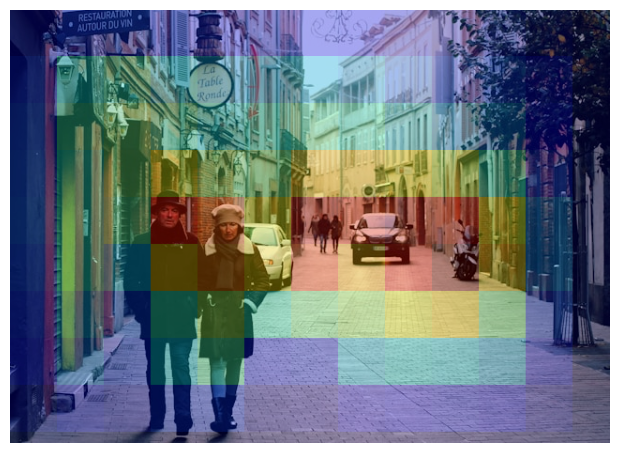

In [48]:
from xplique.plots import plot_attributions
plot_attributions(explanations, tf_inputs, img_size=6.,
                cmap='jet', alpha=0.3, absolute_value=False, clip_percentile=0.5)

2025-09-05 19:54:28.702286: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


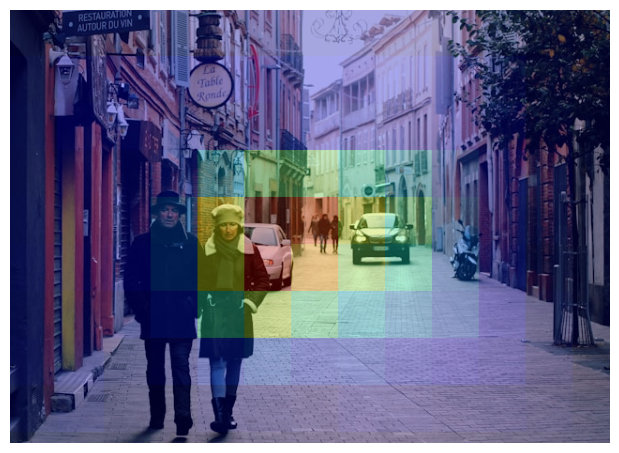

In [49]:
box_to_explain = filter_boxes_tf(targets, class_id=CLASSES.index('car'))
explanations = explainer.explain(tf_inputs, box_to_explain)
plot_attributions(explanations, tf_inputs, img_size=6.,
                cmap='jet', alpha=0.3, absolute_value=False, clip_percentile=0.5)

## Saliency

In [30]:
from xplique.attributions import Saliency
from xplique.commons.operators import object_detection_operator
from xplique.wrappers import TorchWrapper

od_model = od_model.eval()
torch_wrapped_model = TorchWrapper(od_model, device=device, is_channel_first=True)

/home/frederic.boisnard/proj/tmp/xplique_fbo/xplique/wrappers/pytorch.py:61: UserWarning: TF is set to run eagerly to avoid conflict with PyTorch. Thus,                       TF functions might be slower
  warnings.warn("TF is set to run eagerly to avoid conflict with PyTorch. Thus,\


In [31]:
inputs = visualizable_torch_inputs.permute(0, 2, 3, 1)
targets = torch_wrapped_model(inputs)

I0000 00:00:1757094597.907560 3356632 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1052 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/frederic.boisnard/proj/tmp/xplique_fbo/xplique/wrappers/pytorch.py:141: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  torch_inputs = self.torch.Tensor(np_inputs)


In [32]:
print(f"Inputs shape: {inputs.shape}")
print(f"Targets shape: {targets.shape}")

Inputs shape: torch.Size([1, 462, 640, 3])
Targets shape: (1, 300, 96)


In [33]:
import xplique
operator = xplique.Tasks.OBJECT_DETECTION_BOX_PROBA
scores = operator(torch_wrapped_model, inputs, targets[:, 0:1,:])
print(f"final scores = {scores}")

final scores = [0.9920387]


In [52]:
explainer = Saliency(torch_wrapped_model, operator=xplique.Tasks.OBJECT_DETECTION, batch_size=1)

In [60]:
box_to_explain = filter_boxes_tf(targets, class_id=CLASSES.index('person'))
explanations = explainer.explain(inputs, box_to_explain)

Saliency.expain()
inputs type: <class 'tensorflow.python.framework.ops.EagerTensor'>
inputs shape: (1, 462, 640, 3)
inputs dtype: <dtype: 'float32'>
scores type: <class 'tensorflow.python.framework.ops.EagerTensor'>
scores shape: (1,)
scores dtype: <dtype: 'float32'>
KO scores has no requires_grad
KO inputs has no requires_grad
gradients type: <class 'tensorflow.python.framework.ops.EagerTensor'>


2025-09-05 20:02:21.544043: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


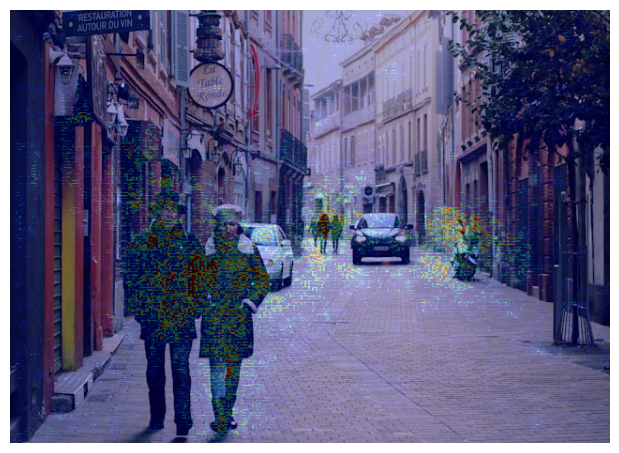

In [59]:
plot_attributions(explanations, tf_inputs, img_size=6.,
                  cmap='jet', alpha=0.3, absolute_value=False, clip_percentile=0.5)

Saliency.expain()
inputs type: <class 'tensorflow.python.framework.ops.EagerTensor'>
inputs shape: (1, 462, 640, 3)
inputs dtype: <dtype: 'float32'>
scores type: <class 'tensorflow.python.framework.ops.EagerTensor'>
scores shape: (1,)
scores dtype: <dtype: 'float32'>
KO scores has no requires_grad
KO inputs has no requires_grad
gradients type: <class 'tensorflow.python.framework.ops.EagerTensor'>


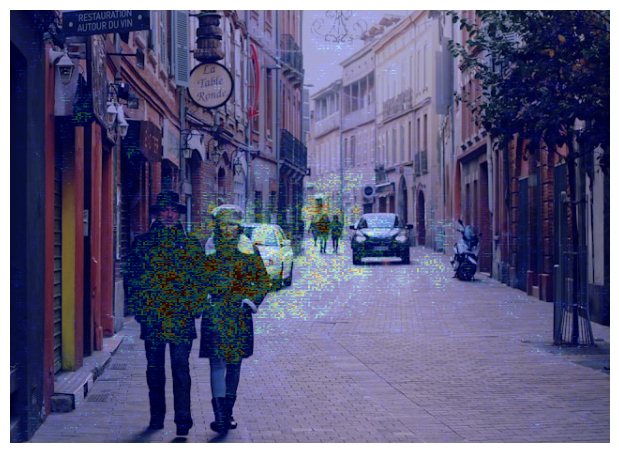

In [61]:
box_to_explain = filter_boxes_tf(targets, class_id=CLASSES.index('car'))
explanations = explainer.explain(inputs, box_to_explain)
plot_attributions(explanations, tf_inputs, img_size=6.,
                  cmap='jet', alpha=0.3, absolute_value=False, clip_percentile=0.5)

In [64]:
# def add_box_to_image_tensor(images, boxes, colors=np.array([[1.0, 1.0, 1.0]])):
#     # function to add rectangle to an image
#     height, width = images.shape[1:-1]
#     print(f"Image shape: {images.shape}, Height: {height}, Width: {width}")
#     print(f"Boxes shape: {boxes.shape}, Boxes: {boxes}")
#     formatted_boxes = tf.stack([
#         boxes[:, :, 1] / height,
#         boxes[:, :, 0] / width,
#         boxes[:, :, 3] / height,
#         boxes[:, :, 2] / width,
#     ], axis=-1)
#     print(f"Formatted boxes: {formatted_boxes}")

#     return tf.image.draw_bounding_boxes(
#         images=images,
#         boxes=formatted_boxes,
#         colors=colors
#     )

# from xplique.attributions import HsicAttributionMethod, Occlusion, Saliency
# from xplique.plots import plot_attributions

# # visualize explanation
# image_with_box = add_box_to_image_tensor(inputs, box_to_explain[:, tf.newaxis, :4],)
# plot_attributions(explanations, image_with_box, img_size=6.,
#                   cmap='jet', alpha=0.3, absolute_value=False, clip_percentile=0.5)